# Import Library 

In [3]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [4]:
spark = SparkSession.builder.appName("TrainModel").getOrCreate()

In [5]:
import os
os.environ["PYSPARK_DRIVER_MEMORY"] = "16g"  # hoặc cao hơn nếu máy đủ RAM

# Read Data

In [6]:
df = spark.read.csv("../data/train_45000.csv", header=True, inferSchema=True)

In [7]:
df.head(5)

[Row(Zone_ID='Z2', Image_Source_ID='IMG_Z2_202505150220.jpg', Image_Type='Multispectral', NDVI=0.79, NDRE=0.2, RGB_Damage_Score=None, UAV_Timestamp='5/15/2025 2:20', N=74, P=22, K=73, Moisture=32.16, pH=5.98, Temperature=40.21, Humidity=61.06, NDI_Label='Medium', PDI_Label='Low', Semantic_Tag='P-deficiency, N-deficiency', Action_Suggested='Irrigate', Energy_Consumed_mAh=6.18, Latency_ms=84.07, Current_Node='Cloud-Node-1', Migrated_To='Cloud-Node-1', Migration_Required='No', Migration_Timestamp=None),
 Row(Zone_ID='Z7', Image_Source_ID='IMG_Z7_202508100610.jpg', Image_Type='RGB', NDVI=None, NDRE=None, RGB_Damage_Score=0.11, UAV_Timestamp='08/10/2025 6:10', N=69, P=28, K=53, Moisture=32.36, pH=7.43, Temperature=19.22, Humidity=35.19, NDI_Label='High', PDI_Label='Low', Semantic_Tag='K-deficiency, Pest-risk', Action_Suggested='Apply Fertilizer', Energy_Consumed_mAh=3.4, Latency_ms=52.67, Current_Node='Cloud-Node-1', Migrated_To='Cloud-Node-1', Migration_Required='No', Migration_Timestamp=N

In [8]:
df.printSchema()

root
 |-- Zone_ID: string (nullable = true)
 |-- Image_Source_ID: string (nullable = true)
 |-- Image_Type: string (nullable = true)
 |-- NDVI: double (nullable = true)
 |-- NDRE: double (nullable = true)
 |-- RGB_Damage_Score: double (nullable = true)
 |-- UAV_Timestamp: string (nullable = true)
 |-- N: integer (nullable = true)
 |-- P: integer (nullable = true)
 |-- K: integer (nullable = true)
 |-- Moisture: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- NDI_Label: string (nullable = true)
 |-- PDI_Label: string (nullable = true)
 |-- Semantic_Tag: string (nullable = true)
 |-- Action_Suggested: string (nullable = true)
 |-- Energy_Consumed_mAh: double (nullable = true)
 |-- Latency_ms: double (nullable = true)
 |-- Current_Node: string (nullable = true)
 |-- Migrated_To: string (nullable = true)
 |-- Migration_Required: string (nullable = true)
 |-- Migration_Timestamp: string (nulla

In [9]:
# Lấy những features cần thiết
features = ['N', 'P', 'K', 'Moisture', 'pH', 'Temperature', 'Humidity', 'NDI_Label', 'PDI_Label']

target_tag = 'Semantic_Tag'
target_a = 'Action_Suggested'

In [10]:
train_df = df.select(features + [target_tag, target_a])
train_df.show(5, truncate=False) 

+---+---+---+--------+----+-----------+--------+---------+---------+--------------------------+----------------+
|N  |P  |K  |Moisture|pH  |Temperature|Humidity|NDI_Label|PDI_Label|Semantic_Tag              |Action_Suggested|
+---+---+---+--------+----+-----------+--------+---------+---------+--------------------------+----------------+
|74 |22 |73 |32.16   |5.98|40.21      |61.06   |Medium   |Low      |P-deficiency, N-deficiency|Irrigate        |
|69 |28 |53 |32.36   |7.43|19.22      |35.19   |High     |Low      |K-deficiency, Pest-risk   |Apply Fertilizer|
|25 |36 |24 |34.35   |6.31|20.53      |68.93   |Low      |Medium   |N-deficiency, K-deficiency|Irrigate        |
|33 |24 |59 |31.89   |5.62|39.07      |84.95   |Medium   |Medium   |K-deficiency, Healthy     |Irrigate        |
|42 |35 |94 |10.33   |5.35|31.93      |84.35   |Medium   |Low      |N-deficiency, N-deficiency|Apply Fertilizer|
+---+---+---+--------+----+-----------+--------+---------+---------+--------------------------+-

In [11]:
from pyspark.sql.functions import split, explode, array_distinct, col
from pyspark.ml.feature import VectorAssembler

# Tách và loại bỏ duplicate
df_exploded = train_df.withColumn("label_array", array_distinct(split(col(target_tag), ", ")))

# Train từng binary classifier cho mỗi label
unique_labels = df_exploded.select(explode(col("label_array"))).distinct().collect()
unique_labels = [row[0] for row in unique_labels]

print("Unique labels:", unique_labels)

# In ra df_exploded để kiểm tra
df_exploded.show(5, truncate=False)

Unique labels: ['P-deficiency', 'Pest-risk', 'N-deficiency', 'K-deficiency', 'Healthy']
+---+---+---+--------+----+-----------+--------+---------+---------+--------------------------+----------------+----------------------------+
|N  |P  |K  |Moisture|pH  |Temperature|Humidity|NDI_Label|PDI_Label|Semantic_Tag              |Action_Suggested|label_array                 |
+---+---+---+--------+----+-----------+--------+---------+---------+--------------------------+----------------+----------------------------+
|74 |22 |73 |32.16   |5.98|40.21      |61.06   |Medium   |Low      |P-deficiency, N-deficiency|Irrigate        |[P-deficiency, N-deficiency]|
|69 |28 |53 |32.36   |7.43|19.22      |35.19   |High     |Low      |K-deficiency, Pest-risk   |Apply Fertilizer|[K-deficiency, Pest-risk]   |
|25 |36 |24 |34.35   |6.31|20.53      |68.93   |Low      |Medium   |N-deficiency, K-deficiency|Irrigate        |[N-deficiency, K-deficiency]|
|33 |24 |59 |31.89   |5.62|39.07      |84.95   |Medium   |Me

In [12]:
train_df = df_exploded.cache()

# Clean Data

In [13]:
from pyspark.sql.functions import col, sum

# Đếm tổng số null cho từng cột
null_counts = train_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in train_df.columns])
null_counts.show()

+---+---+---+--------+---+-----------+--------+---------+---------+------------+----------------+-----------+
|  N|  P|  K|Moisture| pH|Temperature|Humidity|NDI_Label|PDI_Label|Semantic_Tag|Action_Suggested|label_array|
+---+---+---+--------+---+-----------+--------+---------+---------+------------+----------------+-----------+
|  0|  0|  0|       0|  0|          0|       0|        0|        0|           0|               0|          0|
+---+---+---+--------+---+-----------+--------+---------+---------+------------+----------------+-----------+



In [14]:
# Duplicate
duplicate_counts = train_df.groupBy(features).count().filter(col("count") > 1)
duplicate_counts.show()

+---+---+---+--------+---+-----------+--------+---------+---------+-----+
|  N|  P|  K|Moisture| pH|Temperature|Humidity|NDI_Label|PDI_Label|count|
+---+---+---+--------+---+-----------+--------+---------+---------+-----+
+---+---+---+--------+---+-----------+--------+---------+---------+-----+



# EDA 

In [15]:
# Xem phân bố của các class trong target
train_df.groupBy(target_tag).count().orderBy("count", ascending=False).show(10, truncate=False)

+--------------------------+-----+
|Semantic_Tag              |count|
+--------------------------+-----+
|Pest-risk, K-deficiency   |1868 |
|Pest-risk, P-deficiency   |1848 |
|P-deficiency, Pest-risk   |1840 |
|N-deficiency, Pest-risk   |1835 |
|K-deficiency, Pest-risk   |1832 |
|Healthy, P-deficiency     |1828 |
|N-deficiency, Healthy     |1828 |
|P-deficiency, K-deficiency|1826 |
|Pest-risk, N-deficiency   |1824 |
|P-deficiency, P-deficiency|1823 |
+--------------------------+-----+
only showing top 10 rows



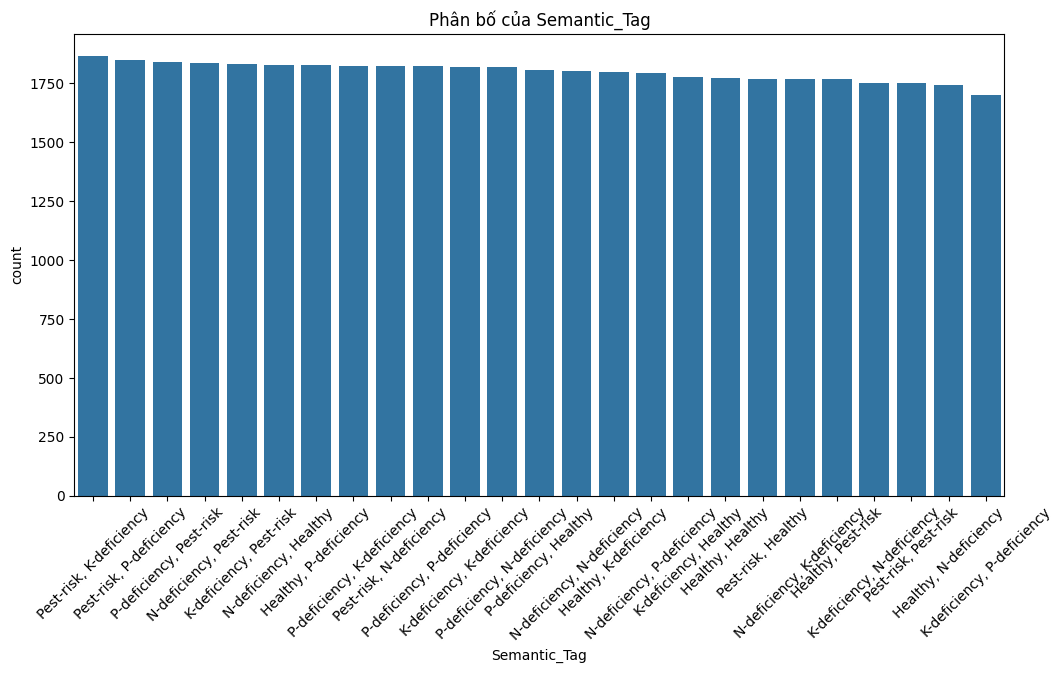

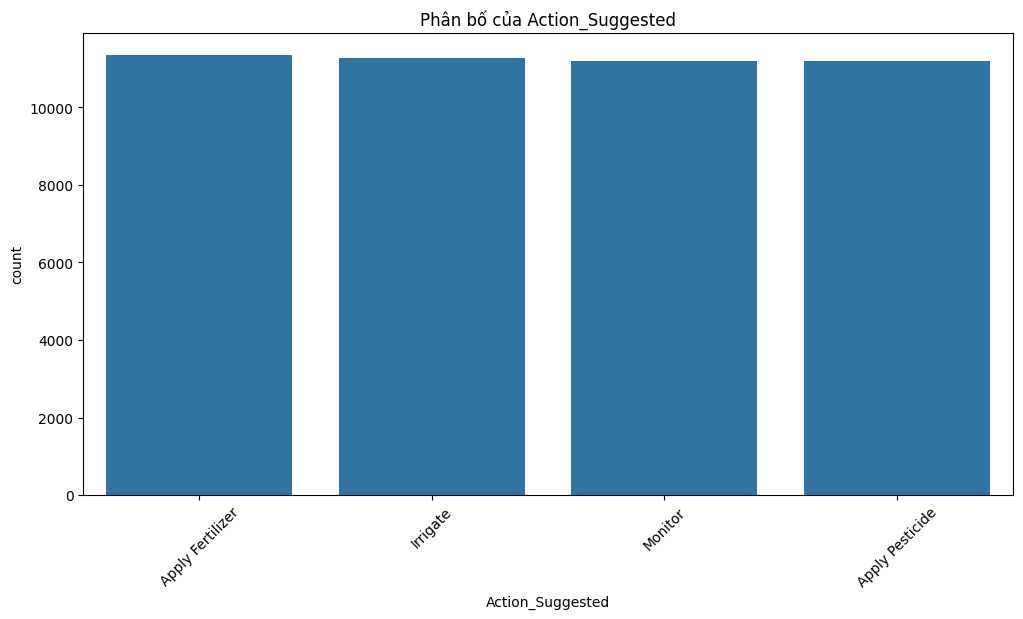

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pdf = train_df.toPandas()
t=[target_tag, target_a]
for i in t:
    plt.figure(figsize=(12,6))
    sns.countplot(data=pdf, x=i, order=pdf[i].value_counts().index)
    plt.title(f'Phân bố của {i}')
    plt.xticks(rotation=45)
    plt.show()

Không có mất cân bằng nhãn 

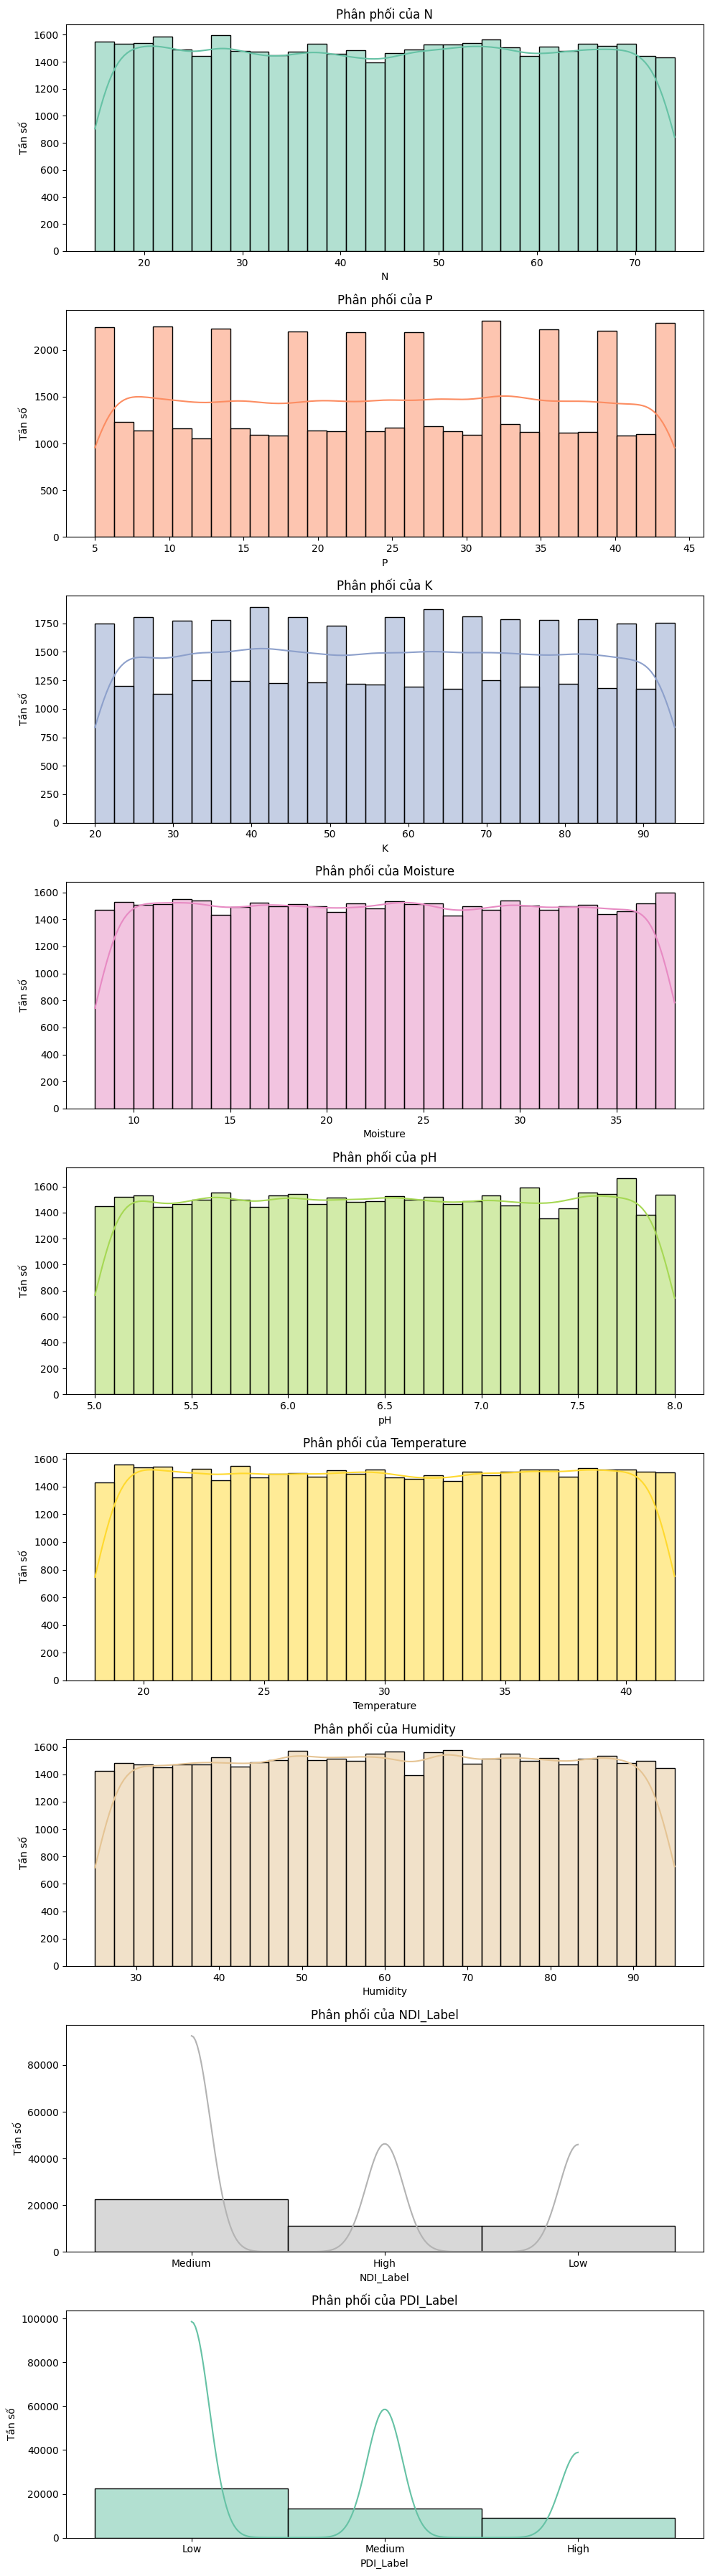

In [17]:
color = sns.color_palette("Set2")
n = len(features)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n)) 

for idx, feature in enumerate(features):
    ax = axes[idx]
    sns.histplot(data=pdf, x=feature, bins=30, kde=True, color=color[idx % len(color)], ax=ax)
    ax.set_title(f'Phân phối của {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Tần số')

plt.tight_layout()
plt.show()

Các đặc trưng N, K, Moisture, pH, Temperature, Humidity đều có phân phối khá đều, không bị lệch rõ rệt, không có outlier lớn, chứng tỏ dữ liệu được lấy mẫu tốt và không có hiện tượng mất cân bằng nghiêm trọng.

Đặc trưng P có dạng phân phối rời rạc, thể hiện qua các cột histogram tách biệt, có thể do giá trị P chỉ nhận các mức nhất định (dữ liệu rời rạc hoặc đã được phân nhóm).

Đường KDE của các feature đều khá mượt, không có đỉnh bất thường, xác nhận dữ liệu không bị nhiễu hoặc lỗi nhập liệu lớn.
Tần số giữa các bins của các feature khá đồng đều, không có bin nào vượt trội hoặc thấp bất thường.
Không có feature nào bị lệch trái/phải mạnh, không có đuôi dài (skewness thấp).

Tóm lại:
Các feature đều có phân phối khá chuẩn, đồng đều, không có dấu hiệu mất cân bằng hoặc outlier lớn. Dữ liệu này phù hợp để huấn luyện các mô hình học máy mà không cần xử lý lại phân phối.

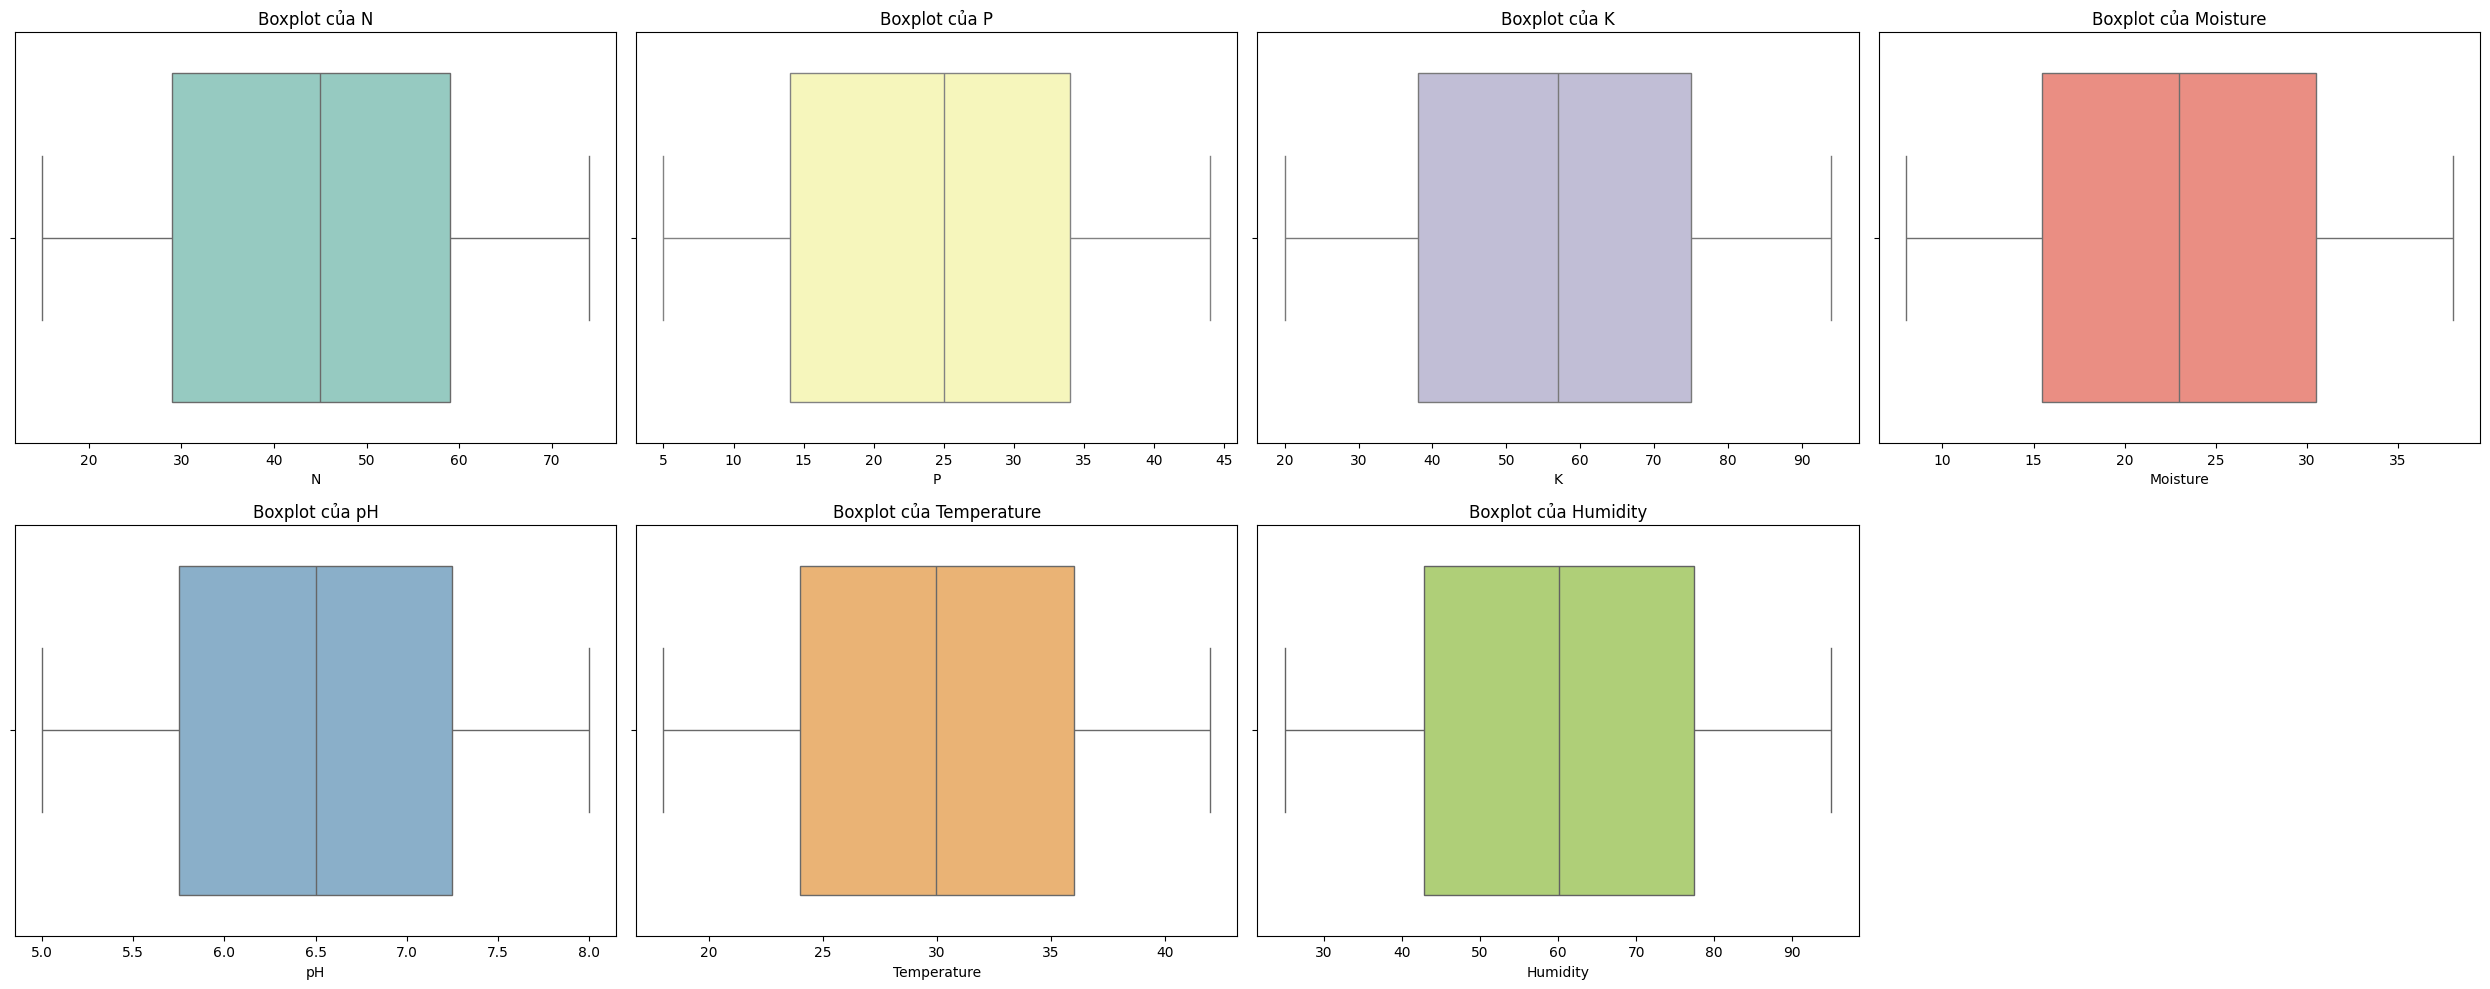

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(25, 10)) 
numeric_features = ['N', 'P', 'K', 'Moisture', 'pH', 'Temperature', 'Humidity'] 
color = sns.color_palette("Set3")
n_features = len(numeric_features)
for idx, feature in enumerate(numeric_features):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]
    sns.boxplot(data=pdf, x=feature, color=color[idx % len(color)], ax=ax)
    ax.set_title(f'Boxplot của {feature}')
    ax.set_xlabel(feature)

# Ẩn ô thừa nếu có
if n_features < 8:
    for idx in range(n_features, 8):
        row = idx // 4
        col = idx % 4
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

In [19]:
# Tính IQR
for feature in numeric_features:
    Q1 = pdf[feature].quantile(0.25)
    Q3 = pdf[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = pdf[(pdf[feature] < lower_bound) | (pdf[feature] > upper_bound)]
    print(f'Feature: {feature}, Số outlier: {len(outliers)}')


Feature: N, Số outlier: 0
Feature: P, Số outlier: 0
Feature: K, Số outlier: 0
Feature: Moisture, Số outlier: 0
Feature: pH, Số outlier: 0
Feature: Temperature, Số outlier: 0
Feature: Humidity, Số outlier: 0


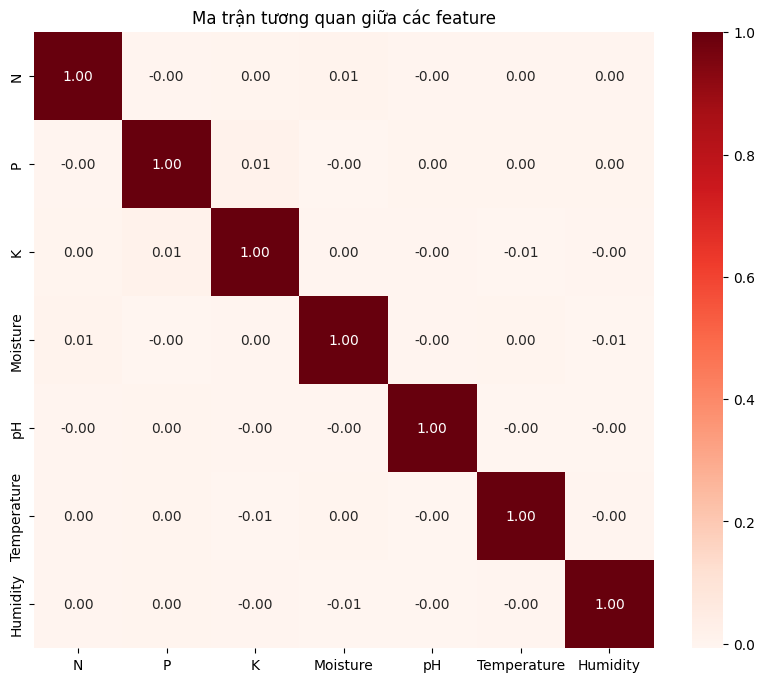

In [20]:
# Tính tương quan
corr_matrix = pdf[numeric_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Reds', fmt=".2f")
plt.title('Ma trận tương quan giữa các feature')
plt.show()


In [21]:
import pandas as pd
from scipy import stats
import numpy as np

print("="*80)
print("CHI-SQUARE TEST: Biến phân loại vs Action_Suggested")
print("="*80)

# Contingency tables
contingency_table_ndi = pd.crosstab(pdf['NDI_Label'], pdf[target_a])
contingency_table_pdi = pd.crosstab(pdf['PDI_Label'], pdf[target_a])
contingency_table_semantic = pd.crosstab(pdf['Semantic_Tag'], pdf[target_a])

print("\n1. NDI_Label vs Action_Suggested:")
print(contingency_table_ndi)
chi2_ndi, p_ndi, dof_ndi, expected_ndi = stats.chi2_contingency(contingency_table_ndi)
print(f"   Chi-square: {chi2_ndi:.4f}, p-value: {p_ndi:.4e}")
print(f"   {'✓ Có tương quan' if p_ndi < 0.05 else '✗ Không có tương quan'} (p < 0.05)")

print("\n2. PDI_Label vs Action_Suggested:")
print(contingency_table_pdi)
chi2_pdi, p_pdi, dof_pdi, expected_pdi = stats.chi2_contingency(contingency_table_pdi)
print(f"   Chi-square: {chi2_pdi:.4f}, p-value: {p_pdi:.4e}")
print(f"   {'✓ Có tương quan' if p_pdi < 0.05 else '✗ Không có tương quan'} (p < 0.05)")

print("\n3. Semantic_Tag vs Action_Suggested:")
print(contingency_table_semantic)
chi2_semantic, p_semantic, dof_semantic, expected_semantic = stats.chi2_contingency(contingency_table_semantic)
print(f"   Chi-square: {chi2_semantic:.4f}, p-value: {p_semantic:.4e}")
print(f"   {'✓ Có tương quan' if p_semantic < 0.05 else '✗ Không có tương quan'} (p < 0.05)")


CHI-SQUARE TEST: Biến phân loại vs Action_Suggested

1. NDI_Label vs Action_Suggested:
Action_Suggested  Apply Fertilizer  Apply Pesticide  Irrigate  Monitor
NDI_Label                                                             
High                          2837             2800      2847     2792
Low                           2770             2784      2790     2848
Medium                        5741             5602      5628     5561
   Chi-square: 3.7550, p-value: 7.0979e-01
   ✗ Không có tương quan (p < 0.05)

2. PDI_Label vs Action_Suggested:
Action_Suggested  Apply Fertilizer  Apply Pesticide  Irrigate  Monitor
PDI_Label                                                             
High                          2274             2241      2218     2193
Low                           5629             5592      5664     5738
Medium                        3445             3353      3383     3270
   Chi-square: 6.9205, p-value: 3.2826e-01
   ✗ Không có tương quan (p < 0.05)

3. Semant

In [22]:
# Tương quan NDI_Label và PDI_Label với Semantic_Tag

contingency_table_ndi = pd.crosstab(pdf['NDI_Label'], pdf[target_tag])
contingency_table_pdi = pd.crosstab(pdf['PDI_Label'], pdf[target_tag])

print("\n1. NDI_Label vs Semantic_Tag:")
print(contingency_table_ndi)
chi2_ndi, p_ndi, dof_ndi, expected_ndi = stats.chi2_contingency(contingency_table_ndi)
print(f"   Chi-square: {chi2_ndi:.4f}, p-value: {p_ndi:.4e}")
print(f"   {'✓ Có tương quan' if p_ndi < 0.05 else '✗ Không có tương quan'} (p < 0.05)")

print("\n2. PDI_Label vs Semantic_Tag:")
print(contingency_table_pdi)
chi2_pdi, p_pdi, dof_pdi, expected_pdi = stats.chi2_contingency(contingency_table_pdi)
print(f"   Chi-square: {chi2_pdi:.4f}, p-value: {p_pdi:.4e}")
print(f"   {'✓ Có tương quan' if p_pdi < 0.05 else '✗ Không có tương quan'} (p < 0.05)")



1. NDI_Label vs Semantic_Tag:
Semantic_Tag  Healthy, Healthy  Healthy, K-deficiency  Healthy, N-deficiency  \
NDI_Label                                                                      
High                       475                    469                    436   
Low                        442                    413                    404   
Medium                     855                    917                    903   

Semantic_Tag  Healthy, P-deficiency  Healthy, Pest-risk  \
NDI_Label                                                 
High                            436                 439   
Low                             473                 429   
Medium                          919                 901   

Semantic_Tag  K-deficiency, Healthy  K-deficiency, K-deficiency  \
NDI_Label                                                         
High                            447                         447   
Low                             494                         425   
Medi

In [23]:
train_df.show(5)

+---+---+---+--------+----+-----------+--------+---------+---------+--------------------+----------------+--------------------+
|  N|  P|  K|Moisture|  pH|Temperature|Humidity|NDI_Label|PDI_Label|        Semantic_Tag|Action_Suggested|         label_array|
+---+---+---+--------+----+-----------+--------+---------+---------+--------------------+----------------+--------------------+
| 74| 22| 73|   32.16|5.98|      40.21|   61.06|   Medium|      Low|P-deficiency, N-d...|        Irrigate|[P-deficiency, N-...|
| 69| 28| 53|   32.36|7.43|      19.22|   35.19|     High|      Low|K-deficiency, Pes...|Apply Fertilizer|[K-deficiency, Pe...|
| 25| 36| 24|   34.35|6.31|      20.53|   68.93|      Low|   Medium|N-deficiency, K-d...|        Irrigate|[N-deficiency, K-...|
| 33| 24| 59|   31.89|5.62|      39.07|   84.95|   Medium|   Medium|K-deficiency, Hea...|        Irrigate|[K-deficiency, He...|
| 42| 35| 94|   10.33|5.35|      31.93|   84.35|   Medium|      Low|N-deficiency, N-d...|Apply Fertilize

Hai biến NDI_Label và PDI_Label không phải là yếu tố quyết định mạnh cho Action_Suggested trong tập dữ liệu này.

In [24]:
# Xem phân bố của các class trong target
train_df.groupBy(target_a).count().show(truncate=False)

+----------------+-----+
|Action_Suggested|count|
+----------------+-----+
|Apply Fertilizer|11348|
|Irrigate        |11265|
|Apply Pesticide |11186|
|Monitor         |11201|
+----------------+-----+



Đa số các feature có p-value > 0.05 với cả hai target (Semantic_Tag và Action_Suggested), nghĩa là không có sự khác biệt có ý nghĩa thống kê giữa các nhóm target theo từng feature này.

Một số feature như N, pH, Temperature, Humidity có p-value thấp hơn (gần hoặc dưới 0.2), nhưng chỉ có Temperature và pH với Action_Suggested là gần sát mức ý nghĩa.

Không có feature nào có p-value < 0.05 (dưới đường đỏ), tức là không có feature nào thực sự phân biệt rõ ràng giữa các nhóm target theo kiểm định ANOVA.

P và K có p-value rất cao, cho thấy chúng gần như không liên quan đến sự khác biệt giữa các nhóm target.

In [25]:
train_df.show(5)

+---+---+---+--------+----+-----------+--------+---------+---------+--------------------+----------------+--------------------+
|  N|  P|  K|Moisture|  pH|Temperature|Humidity|NDI_Label|PDI_Label|        Semantic_Tag|Action_Suggested|         label_array|
+---+---+---+--------+----+-----------+--------+---------+---------+--------------------+----------------+--------------------+
| 74| 22| 73|   32.16|5.98|      40.21|   61.06|   Medium|      Low|P-deficiency, N-d...|        Irrigate|[P-deficiency, N-...|
| 69| 28| 53|   32.36|7.43|      19.22|   35.19|     High|      Low|K-deficiency, Pes...|Apply Fertilizer|[K-deficiency, Pe...|
| 25| 36| 24|   34.35|6.31|      20.53|   68.93|      Low|   Medium|N-deficiency, K-d...|        Irrigate|[N-deficiency, K-...|
| 33| 24| 59|   31.89|5.62|      39.07|   84.95|   Medium|   Medium|K-deficiency, Hea...|        Irrigate|[K-deficiency, He...|
| 42| 35| 94|   10.33|5.35|      31.93|   84.35|   Medium|      Low|N-deficiency, N-d...|Apply Fertilize

# MODEL DỰ ĐOÁN NHÃN ACTION_SUGGESTED

In [26]:
train_data, test_data = train_df.randomSplit([0.8, 0.2], seed=42)

In [27]:
train_pd = train_data.toPandas() 
test_pd = test_data.toPandas()
 
le = LabelEncoder()
train_pd['label'] = le.fit_transform(train_pd['Action_Suggested'])
test_pd['label'] = le.transform(test_pd['Action_Suggested'])

ndi_le = LabelEncoder()
pdi_le = LabelEncoder()
train_pd['NDI_encoded'] = ndi_le.fit_transform(train_pd['NDI_Label'])
test_pd['NDI_encoded'] = ndi_le.transform(test_pd['NDI_Label'])
train_pd['PDI_encoded'] = pdi_le.fit_transform(train_pd['PDI_Label'])
test_pd['PDI_encoded'] = pdi_le.transform(test_pd['PDI_Label'])

def create_nonlinear_features(df):
    features = pd.DataFrame()
    features['N_log'] = np.log1p(df['N'])
    features['P_log'] = np.log1p(df['P'])
    features['K_log'] = np.log1p(df['K'])
    features['Moisture_sqrt'] = np.sqrt(df['Moisture'])
    features['pH_square'] = df['pH'] ** 2
    features['Temperature_square'] = df['Temperature'] ** 2 
    features['Humidity_sqrt'] = np.sqrt(df['Humidity'])

    features['NP_interaction'] = features['N_log'] * features['P_log']
    features['Moisture_Temp'] = features['Moisture_sqrt'] * df['Temperature']
    features['NDI_encoded'] = df['NDI_encoded']
    features['PDI_encoded'] = df['PDI_encoded']
    
    return features.values

X_train = create_nonlinear_features(train_pd)
X_test = create_nonlinear_features(test_pd)

y_train = train_pd['label']
y_test = test_pd['label']


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.1, 0.3],
    'n_estimators': [100],
    'min_child_weight': [3],
    'subsample': [0.9],
    'tree_method': ['hist'],  
    'predictor': ['gpu_predictor'], 
   
}

base_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    random_state=42,
    enable_categorical=True,
    seed=42,
    tree_method='hist',
    predictor='gpu_predictor',
)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,  
    scoring='accuracy',
    n_jobs=1,  
    verbose=1
)

print("Starting grid search...")
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")

train_pred = best_model.predict(X_train_scaled)
test_pred = best_model.predict(X_test_scaled)

print("\nResults:")
print(f"Train Accuracy: {accuracy_score(y_train, train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred):.4f}")

print("\nClassification Report:")
print(classification_report(
    y_test, 
    test_pred,
    target_names=le.classes_,
    digits=4
))

feature_names = [
    'N_log', 'P_log', 'K_log', 'Moisture_sqrt', 'pH_square',
    'Temperature_square', 'Humidity_sqrt', 'NP_interaction',
    'Moisture_Temp', 'NDI_encoded', 'PDI_encoded'
]

importances = dict(zip(feature_names, best_model.feature_importances_))
sorted_imp = sorted(importances.items(), key=lambda x: x[1], reverse=True)

print("\nTop Feature Importances:")
for feat, imp in sorted_imp:
    print(f"{feat}: {imp:.4f}")

Starting grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:47:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:47:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:47:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:47:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\


Best parameters: {'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'predictor': 'gpu_predictor', 'subsample': 0.9, 'tree_method': 'hist'}

Results:
Train Accuracy: 0.8147
Test Accuracy: 0.2496

Classification Report:
                  precision    recall  f1-score   support

Apply Fertilizer     0.2544    0.2544    0.2544      2241
 Apply Pesticide     0.2469    0.2568    0.2518      2196
        Irrigate     0.2437    0.2586    0.2509      2158
         Monitor     0.2540    0.2294    0.2411      2271

        accuracy                         0.2496      8866
       macro avg     0.2497    0.2498    0.2495      8866
    weighted avg     0.2498    0.2496    0.2495      8866


Top Feature Importances:
Moisture_Temp: 0.0942
Temperature_square: 0.0933
NP_interaction: 0.0925
PDI_encoded: 0.0922
Moisture_sqrt: 0.0920
pH_square: 0.0918
Humidity_sqrt: 0.0907
K_log: 0.0893
N_log: 0.0890
P_log: 0.0878
NDI_encoded: 0.0872


<Figure size 2000x8400 with 0 Axes>

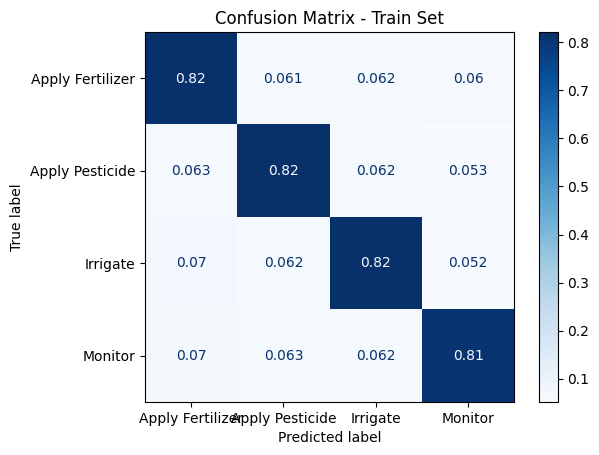

In [ ]:
# Save models to /models directory
import pickle

os.makedirs("../models", exist_ok=True)
    
with open("../models/action_model.pkl", 'wb') as f:
    pickle.dump(best_model, f)
with open("../models/action_scaler.pkl", 'wb') as f:
    pickle.dump(scaler, f)
with open("../models/action_encoder.pkl", 'wb') as f:
    pickle.dump(le, f)
print("Models saved to /models directory!")

Models saved to /models directory!
